# ✅ CUDA check functions

Header file containing basic standard CUDA help functions

In [1]:
%%writefile common.h

#include <sys/time.h>

#ifndef _COMMON_H
#define _COMMON_H

#define CHECK(call)                                                            \
{                                                                              \
    const cudaError_t error = call;                                            \
    if (error != cudaSuccess)                                                  \
    {                                                                          \
        fprintf(stderr, "Error: %s:%d, ", __FILE__, __LINE__);                 \
        fprintf(stderr, "code: %d, reason: %s\n", error,                       \
                cudaGetErrorString(error));                                    \
    }                                                                          \
}

inline double seconds() {
    struct timeval tp;
    struct timezone tzp;
    int i = gettimeofday(&tp, &tzp);
    return ((double)tp.tv_sec + (double)tp.tv_usec * 1.e-6);
}

inline void device_name() {
    // set up device
    int dev = 0;
    cudaDeviceProp deviceProp;
    CHECK(cudaGetDeviceProperties(&deviceProp, dev));
    printf("device %d: %s\n", dev, deviceProp.name);
    CHECK(cudaSetDevice(dev));
}

#endif

Writing common.h


# ✅ Data structures

Header file containing all the data structures and their respective functions

In [2]:
%%writefile datastructures.h

//Background distance
#define INF 2e10f

//Random numbers generator
#define rnd( x ) (x * rand() / RAND_MAX)

//Struct used to implement 3D spheres
struct Sphere {
    
    //r, g and b stand for red, blue, green: the three colours composing each pixel of the image  
    float   r,b,g;

    //Radius is the radius of the sphere
    float   radius;

    //x, y and z are the coordinates that determine the location of the sphere
    float   x,y,z;
};

//WriteBitmap is in charge of building the .bmp format image by filling 
//the 54 bytes header and then writing the values r, b and g for each pixel 
void WriteBitmap(char* fn, unsigned char *pixels, int imageDim, int imageSize) {
    
    //Write down 54 bytes header where the first 14 bytes contain general informations
    //while the last 40 bytes provide detatailed informations
    unsigned char bmpfileheader[14] = {'B','M', 0,0,0,0, 0,0, 0,0, 54,0,0,0};
    unsigned char bmpinfoheader[40] = {40,0,0,0, 0,0,0,0, 0,0,0,0, 1,0, 24,0};

    //Fill general informations bytes from 3 to 6 with the file total dimensions: pixels * pixels * 3
    //where 3 are the three colours r, b and g
    bmpfileheader[ 2] = (unsigned char)(imageSize    );
    bmpfileheader[ 3] = (unsigned char)(imageSize>> 8);
    bmpfileheader[ 4] = (unsigned char)(imageSize>>16);
    bmpfileheader[ 5] = (unsigned char)(imageSize>>24);

    //Fill detailed informations bytes from 5 to 8 with the width of the image
    bmpinfoheader[ 4] = (unsigned char)(imageDim    );
    bmpinfoheader[ 5] = (unsigned char)(imageDim>> 8);
    bmpinfoheader[ 6] = (unsigned char)(imageDim>>16);
    bmpinfoheader[ 7] = (unsigned char)(imageDim>>24);

    //Fill detailed informations bytes from 9 to 12 with the height of the image
    bmpinfoheader[ 8] = (unsigned char)(imageDim    );
    bmpinfoheader[ 9] = (unsigned char)(imageDim>> 8);
    bmpinfoheader[10] = (unsigned char)(imageDim>>16);
    bmpinfoheader[11] = (unsigned char)(imageDim>>24);

    //Try to create or overwrite the image file
    FILE* f = fopen(fn, "w");
    if (f == NULL) {
      printf("\n\nFILE CREATION ERROR: %s\n\n", fn);
      exit(1);
    }

    //Firstly write 54 header bytes
    fwrite(bmpfileheader,1,14,f);
    fwrite(bmpinfoheader,1,40,f);

    //Then write all the r, b and g values of each pixel
    fwrite(pixels, sizeof(unsigned char), imageSize, f);

    //Print the results
    printf("\nOutput File name: %5s  (%u x %u)   File Size=%u\n\n", fn, imageDim, imageDim, imageSize);

    //Free the memory from the pixels array
    free(pixels);

    //Close the file
    fclose(f);
}

Writing datastructures.h


# ✅ Ray tracing

The ray tracing functions place a coordinate system centered right in the middle of the image, then they start tracing rays from the pixels to determine whether spheres are hit or not and to find which sphere is the closest one the camera. If no sphere is found the pixel colours are set to a default colour, otherwise they're set equal to the colours of the closest sphere and then scaled lighter or darker according to depth of the point of the hit sphere.

* CPU ray tracing

In [3]:
%%writefile CPUfunctions.h

//CPUHit checks if a ray hits a sphere
float CPUHit( Sphere s, float ox, float oy, float *n) {
    float dx = ox - (s.x);
    float dy = oy - (s.y);
    if (dx*dx + dy*dy < (s.radius)*(s.radius)) {
        float dz = sqrtf( (s.radius)*(s.radius) - dx*dx - dy*dy );
        *n = dz / sqrtf( (s.radius)*(s.radius) );
        return dz + s.z;
    }
    return -INF;
}

//CPURayTracing performs ray tracing by sequentially tracing a ray from each pixel
//to check which is the nearest object to the camera in front of that pixel
void CPURayTracing( Sphere *s, unsigned char *ptr, int imageDim, int numSpheres) {

    for(int x = 0; x < imageDim; x++){
        for(int y=0; y < imageDim; y++){

            int offset = y + x * imageDim;
            float   ox = (x - imageDim/2);
            float   oy = (y - imageDim/2);

            float   r=0, g=0, b=0;
            float   maxz = -INF;
            float   n;
            float   t = 0;

            for(int i=0; i<numSpheres; i++) {

                t = CPUHit (s[i], ox, oy, &n);

                if (t > maxz) {
                    float fscale = n;
                    r = s[i].r * fscale;
                    g = s[i].g * fscale;
                    b = s[i].b * fscale;
                    maxz = t;
                }
            }

            //Fill the pixel r, b and g components with the hit results from the ray
            ptr[offset*3 + 0] = (unsigned char)(r * 255);
            ptr[offset*3 + 1] = (unsigned char)(g * 255);
            ptr[offset*3 + 2] = (unsigned char)(b * 255);
        }
    }
}

Writing CPUfunctions.h


* GPU ray tracing

In [4]:
%%writefile GPUfunctions.h

//GPUHit checks if a ray hits a sphere
__device__ void GPUHit( Sphere s, float ox, float oy, float *n, float *returnValue) {
    float dx = ox - (s.x);
    float dy = oy - (s.y);
    if (dx*dx + dy*dy < (s.radius)*(s.radius)) {
        float dz = sqrtf( (s.radius)*(s.radius) - dx*dx - dy*dy );
        *n = dz / sqrtf( (s.radius)*(s.radius) );
        *returnValue = dz + s.z;
        return;
    }
    *returnValue = -INF;
    return;
}

//GPURayTracing improves ray tracing performances by handling the tracing of rays
//from different pixels in parallel instead of one by one sequentially
__global__ void GPURayTracing( Sphere *s, unsigned char *ptr, int imageDim, int numSpheres) {
    //Map from threadIdx/BlockIdx to pixel position
    int x = threadIdx.x + blockIdx.x * blockDim.x;
    int y = threadIdx.y + blockIdx.y * blockDim.y;
    int offset = x + y * blockDim.x * gridDim.x;
    float   ox = (x - imageDim/2);
    float   oy = (y - imageDim/2);

    float   r=0, g=0, b=0;
    float   maxz = -INF;
    
    for(int i=0; i<numSpheres; i++) {
        float   n;
        float   t = 0;

        GPUHit (s[i], ox, oy, &n, &t);

        if (t > maxz) {
            float fscale = n;
            r = s[i].r * fscale;
            g = s[i].g * fscale;
            b = s[i].b * fscale;
            maxz = t;
        }
    }

    //Fill the pixel r, b and g components with the hit results from the ray
    ptr[offset*3 + 0] = (unsigned char)(r * 255);
    ptr[offset*3 + 1] = (unsigned char)(g * 255);
    ptr[offset*3 + 2] = (unsigned char)(b * 255);

}

Writing GPUfunctions.h


# ✅ Main

* Main CUDA file

In [5]:
%%writefile RayTracingCUDA.cu

#include <cuda.h>
#include <stdio.h>
#include <stdlib.h>
#include <time.h>
#include "common.h"
#include "datastructures.h"
#include "CPUfunctions.h"
#include "GPUfunctions.h"

int main(int argc, char **argv) {

    //Variable to store the lateral dimension of the image
    int imageDim;

    //Variable to store the total size of the image
    int imageSize;

    //Variable to store the number of spheres in the image
    int numSpheres;

    //Check that parameters are correct
    if (argc != 3) {
        printf("Incorrect use\nUse: ./RayTracingCUDA DIMENSION SPHERES\n");
        return (EXIT_FAILURE);
    } else {
        if(atoi(argv[1]) > 0) {
            imageDim = atoi(argv[1]);
            //Add padding to get a multiple of 16
            imageDim % 16 == 0 ? imageDim = imageDim : imageDim = imageDim + 16 - (imageDim % 16);
            }
        else{
            printf("Dimension must be positive\n");
            return (EXIT_FAILURE);
        }
        imageSize = imageDim * imageDim * 3;

        if(atoi(argv[2]) > 0) numSpheres = atoi(argv[2]);
        else{
            printf("Number of spheres must be positive\n");
            return (EXIT_FAILURE);
        }
    }

    //Bitmap image pixels
    unsigned char *pixelsToChange = new unsigned char[imageSize];
    
    //Random numbers generator initialization
    srand(time(NULL));

    //Parameters to store the results of ray tracing
    unsigned char *dev_bitmap = pixelsToChange;
    struct Sphere *s;

    //Parameters to determine the CPU time required by ray tracing
    float CPUtime;
    clock_t begin, end;


    //Allocate memory on the GPU for the output bitmap
    CHECK( cudaMalloc( (void**)&dev_bitmap, sizeof(unsigned char) * imageSize ) );
    
    //Allocate memory for the Sphere dataset
    CHECK( cudaMalloc( (void**)&s, sizeof(Sphere) * numSpheres ) );

    //Spheres generation
    Sphere *temp_s = (Sphere*)malloc( sizeof(Sphere) * numSpheres );
    for (int i=0; i<numSpheres; i++) {
        temp_s[i].r = rnd( 1.0f );
        temp_s[i].g = rnd( 1.0f );
        temp_s[i].b = rnd( 1.0f );
        temp_s[i].x = rnd( float(imageDim) ) - abs(imageDim/2);
        temp_s[i].y = rnd( float(imageDim) ) - abs(imageDim/2);
        temp_s[i].z = rnd( float(imageDim) ) - abs(imageDim/2);
        temp_s[i].radius = rnd( float(imageDim / 10) ) + (imageDim / 100);
    }

    //Start of CPU version

    begin = clock();
    CPURayTracing(temp_s, pixelsToChange, imageDim, numSpheres);
    end = clock();
    
    //Calculate and print elapsed time after converting it into milliseconds
    CPUtime = ((float) (end - begin) / CLOCKS_PER_SEC) * 1000; //Time is in seconds so it has to converted to milliseconds by mulitplying it by 1000
    printf("\nCPU times: final is end - start = %f ms", CPUtime);

    //Write resulting bitmap image to disk
    WriteBitmap((char *)"RayTracing.bmp", pixelsToChange, imageDim, imageSize);

    //End of CPU version

    //Start of GPU version

    //Allocate memory on the GPU for the output bitmap
    CHECK( cudaMalloc( (void**)&dev_bitmap, sizeof(unsigned char) * imageSize ) );
    
    //Allocate memory for the Sphere dataset
    CHECK( cudaMalloc( (void**)&s, sizeof(Sphere) * numSpheres ) );

    CHECK( cudaMemcpy( s, temp_s, sizeof(Sphere) * numSpheres, cudaMemcpyHostToDevice ) );
    free( temp_s );

    //Create cuda events to calculate elapsed time from ray tracing 
    cudaEvent_t start, stop;
    CHECK( cudaEventCreate(&start) );
    CHECK( cudaEventCreate(&stop) );

    //Generate a bitmap from our spheres data
    dim3    grids(imageDim/16,imageDim/16);
    dim3    threads(16,16);
    CHECK( cudaEventRecord(start) );
    GPURayTracing<<<grids,threads>>>( s, dev_bitmap, imageDim, numSpheres);
    CHECK( cudaEventRecord(stop) );

    CHECK( cudaEventSynchronize(stop) );

    float GPUtime; //cudaEventElapsedTime returns time in milliseconds!
    CHECK( cudaEventElapsedTime( &GPUtime, start, stop ) );
    printf("Kernel time: %f in ms", GPUtime );

    //Copy results from device GPU memory back to host (CPU) memory
    CHECK( cudaMemcpy( pixelsToChange, dev_bitmap, sizeof(unsigned char) * imageSize, cudaMemcpyDeviceToHost ) );

    //Write resulting bitmap image to disk
    WriteBitmap((char *)"RayTracing.bmp", pixelsToChange, imageDim, imageSize);

    //Deallocate CPU, GPU memory and destroy events
    cudaFree(dev_bitmap);

    //End of GPU version

    //Free memory
    free(pixelsToChange);

    //cudaDeviceReset must be called before exiting in order for profiling and
    //tracing tools spel as Parallel Nsight and Visual Profiler to show complete traces.
    cudaError_t	cudaStatus = cudaDeviceReset();
    if (cudaStatus != cudaSuccess) {
      fprintf(stderr, "cudaDeviceReset failed!");
      exit(EXIT_FAILURE);
    }

    //Print resulting speed-up data
    printf ("Speed-up achieved: %f", ((double) CPUtime * 1000) / ((double) GPUtime * 1000));

    return (EXIT_SUCCESS);
}

Writing RayTracingCUDA.cu


# ✅ Compile and run

Compile and launch the CUDA script

In [9]:
!nvcc RayTracingCUDA.cu -o RayTracingCUDA -arch=sm_37 -rdc=true -lcudadevrt
!./RayTracingCUDA 1440 25

nvcc warning : The 'compute_35', 'compute_37', 'compute_50', 'sm_35', 'sm_37' and 'sm_50' architectures are deprecated, and may be removed in a future release (Use -Wno-deprecated-gpu-targets to suppress warning).

CPU times: final is end - start = 464.834991 ms
Output File name: RayTracing.bmp  (1440 x 1440)   File Size=6220800

Kernel time: 0.956416 in ms
Output File name: RayTracing.bmp  (1440 x 1440)   File Size=6220800

Speed-up achieved: 486.017576

# ✅ Results


Simple python script that uses openCV to show the ray tracing results from the bitmap image

Image size:  (1440, 1440, 3)


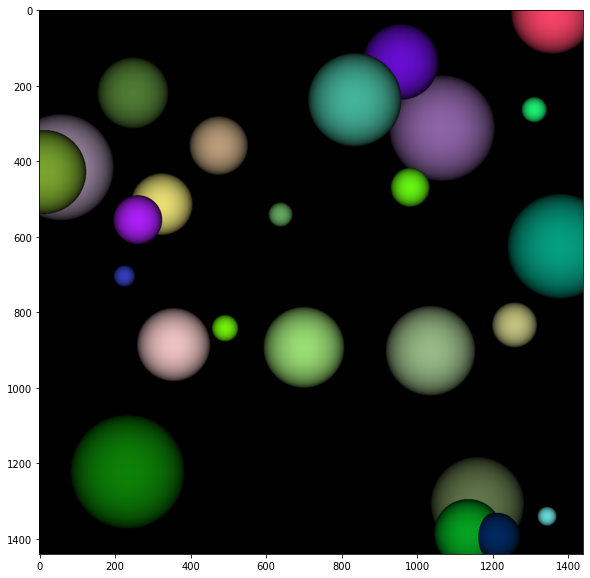

In [10]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# reads as a NumPy array: row (height) x column (width) x color (3)
img1 = cv.imread('RayTracing.bmp')     
print('Image size: ', img1.shape)
# BGR is converted to RGB         
img1 = cv.cvtColor(img1, cv.COLOR_BGR2RGB) 
plt.figure(figsize=(10, 10))
plt.imshow(img1)
plt.show()

# ✅ Speed-up results

Collected data about speed-up with different image dimensions and number of spheres

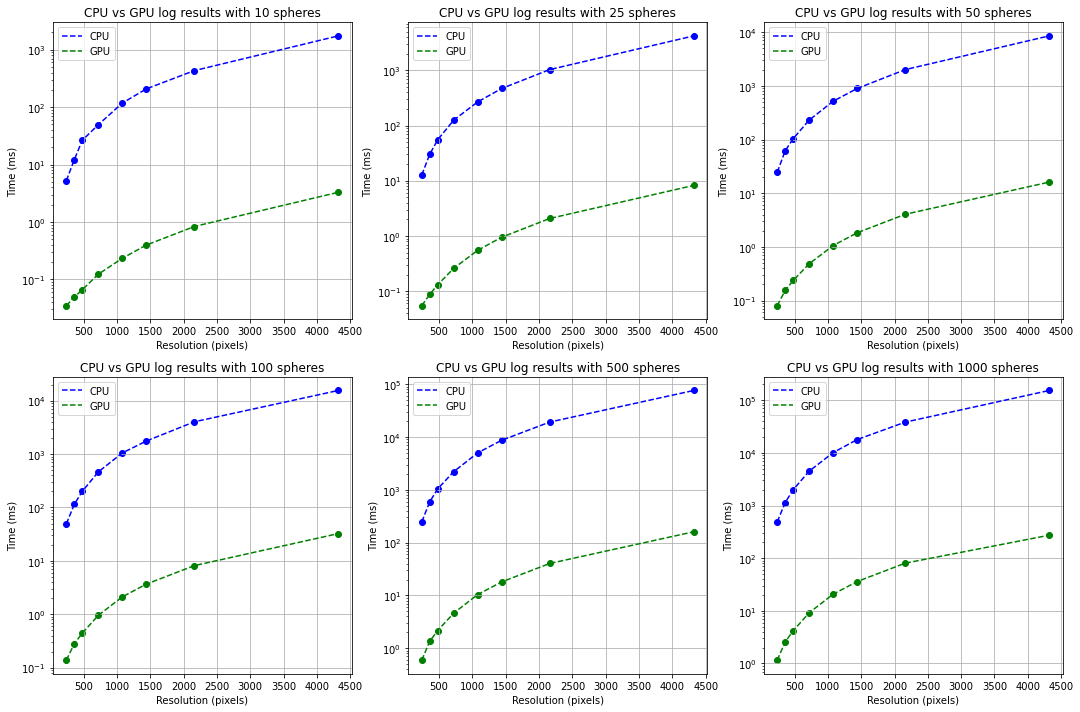

In [8]:
resolutions = [240, 360, 480, 720, 1080, 1440, 2160, 4320]

plt.subplots(2, 3, figsize=(15, 10))

#10 Spheres
CPU_times_10spheres = [5.211, 12.13, 26.464001, 49.369999, 117.493004, 207.688995, 432.001007, 1739.880981]
GPU_times_10spheres = [0.034816, 0.049152, 0.066176, 0.123040, 0.232960, 0.396000, 0.833504, 3.287040]

plt.subplot(2, 3, 1)
plt.title("CPU vs GPU log results with 10 spheres")
plt.xlabel("Resolution (pixels)")
plt.xscale("linear")
plt.ylabel("Time (ms)")
plt.yscale("log")
plt.scatter(resolutions, CPU_times_10spheres, c="b")
plt.scatter(resolutions, GPU_times_10spheres, c="g")
plt.plot(resolutions, CPU_times_10spheres, "b--", label="CPU")
plt.plot(resolutions, GPU_times_10spheres, "g--", label="GPU")
plt.legend(loc="best")
plt.grid()

#25 Spheres
CPU_times_25spheres = [12.698999, 30.194, 55.487, 125.208008, 267.868988, 468.08902, 1028.89209, 4190.733887]
GPU_times_25spheres = [0.054720, 0.087808, 0.131232, 0.260288, 0.551296, 0.951776, 2.074624, 8.237728]

plt.subplot(2, 3, 2)
plt.title("CPU vs GPU log results with 25 spheres")
plt.xlabel("Resolution (pixels)")
plt.xscale("linear")
plt.ylabel("Time (ms)")
plt.yscale("log")
plt.scatter(resolutions, CPU_times_25spheres, c="b")
plt.scatter(resolutions, GPU_times_25spheres, c="g")
plt.plot(resolutions, CPU_times_25spheres, "b--", label="CPU")
plt.plot(resolutions, GPU_times_25spheres, "g--", label="GPU")
plt.legend(loc="best")
plt.grid()

#50 Spheres
CPU_times_50spheres = [24.452999, 61.542, 103.624001, 229.886993, 516.789001, 893.312988, 2002.686035, 8520.464844]
GPU_times_50spheres = [0.080064, 0.154112, 0.236576, 0.48336, 1.058816, 1.828864, 4.043104, 16.070047]

plt.subplot(2, 3, 3)
plt.title("CPU vs GPU log results with 50 spheres")
plt.xlabel("Resolution (pixels)")
plt.xscale("linear")
plt.ylabel("Time (ms)")
plt.yscale("log")
plt.scatter(resolutions, CPU_times_50spheres, c="b")
plt.scatter(resolutions, GPU_times_50spheres, c="g")
plt.plot(resolutions, CPU_times_50spheres, "b--", label="CPU")
plt.plot(resolutions, GPU_times_50spheres, "g--", label="GPU")
plt.legend(loc="best")
plt.grid()

#100 Spheres
CPU_times_100spheres = [49.095001, 114.097, 200.638, 462.903992, 1049.167969, 1754.691040, 4019.610840, 15523.879883]
GPU_times_100spheres = [0.137248, 0.280832, 0.442368, 0.952320, 2.115872, 3.665056, 8.136736, 32.3936]

plt.subplot(2, 3, 4)
plt.title("CPU vs GPU log results with 100 spheres")
plt.xlabel("Resolution (pixels)")
plt.xscale("linear")
plt.ylabel("Time (ms)")
plt.yscale("log")
plt.scatter(resolutions, CPU_times_100spheres, c="b")
plt.scatter(resolutions, GPU_times_100spheres, c="g")
plt.plot(resolutions, CPU_times_100spheres, "b--", label="CPU")
plt.plot(resolutions, GPU_times_100spheres, "g--", label="GPU")
plt.legend(loc="best")
plt.grid()

#500 Spheres
CPU_times_500spheres = [246.283997, 592.979004, 1044.850953, 2208.664795, 5013.866699, 8692.506836, 19180.689453, 76036.546875]
GPU_times_500spheres = [0.589664, 1.355168, 2.162656, 4.616736, 10.397696, 18.031809, 40.251392, 160.346405]

plt.subplot(2, 3, 5)
plt.title("CPU vs GPU log results with 500 spheres")
plt.xlabel("Resolution (pixels)")
plt.xscale("linear")
plt.ylabel("Time (ms)")
plt.yscale("log")
plt.scatter(resolutions, CPU_times_500spheres, c="b")
plt.scatter(resolutions, GPU_times_500spheres, c="g")
plt.plot(resolutions, CPU_times_500spheres, "b--", label="CPU")
plt.plot(resolutions, GPU_times_500spheres, "g--", label="GPU")
plt.legend(loc="best")
plt.grid()

#1000 Spheres
CPU_times_1000spheres = [486.503998, 1139.011963, 1996.479004, 4496.378906, 10126.367188, 17915.726562, 38353.781250, 153154.828125]
GPU_times_1000spheres = [1.148928, 2.573856, 4.184064, 9.189889, 20.729889, 35.999714, 80.389725, 272.889862]

plt.subplot(2, 3, 6)
plt.title("CPU vs GPU log results with 1000 spheres")
plt.xlabel("Resolution (pixels)")
plt.xscale("linear")
plt.ylabel("Time (ms)")
plt.yscale("log")
plt.scatter(resolutions, CPU_times_1000spheres, c="b")
plt.scatter(resolutions, GPU_times_1000spheres, c="g")
plt.plot(resolutions, CPU_times_1000spheres, "b--", label="CPU")
plt.plot(resolutions, GPU_times_1000spheres, "g--", label="GPU")
plt.legend(loc="best")
plt.grid()

plt.tight_layout()